# Project scope

Create a classifier that predicts how my day was based on inputs.

Simplest possible pipeline just uses the productive and unproductive hours. 

Assumptions: the survey methodology was consistent throughout (which it mostly was). So I'm looking to predict how my day will be based on what I do during the day. It doesn't predict what I do during my day (I guess we could do that too, but it would be wildly inaccurate without a pretty insane number of features). 

The hours are a number from one through 8 (I was inconsistent with that, sometimes I would write higher numbers but really it should cap at 8). So there's a preprocessing step there.

Note this is a pretty small amount of data.

In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')

# Get data

The data is from Sheets - I can even do my cleaning there if I want. That's probably better for the actual correction of individual pieces of data. But if there is actual preprocessing that needs to be done, it should be done in Python.

I'm doing some preprocessing here, but this should probably be done in a separate.py file before the train/test split here.

Irrelevant features just shouldn't be here, either because they're personal notes or used in dashboard calculation. Might be better to just make a download sheet in the dashboard.

In [2]:
path = "base data (dnc)/Daily Recap (Responses) - RAW form responses.csv"
raw_target = 'How would you rate your overall satisfaction for the day?'

df = pd.read_csv(path).dropna(subset=[raw_target])  # drop missing target values

# ordinally encode target
target_map = {"Terrible day": 0, "Not great day": 1, "Okay day": 2, "Good day": 3, "Incredible day": 4}
df['target'] = df[raw_target].replace(target_map)
target = 'target'

# numerical features should be limited at 8 for consistency
hours_features = ['Productive Hours', 'Productive AI Hours', 'Unproductive Hours']
for f in hours_features:
    df[f] = df[f].apply(lambda x: x if x < 8 else 8)
    
# should probably have some column renaming as well...

# remove irrelevant features
irrelevant_features = ['Last 7 days?', 'Last 30 days?', 'Was today a free day?', 'Notes', 'Weekday']
df.drop(irrelevant_features, axis=1, inplace=True)

# train/test split
train, test, y, y_test = train_test_split(df.drop([target, raw_target], axis=1), df[target], random_state = 0)
# train.columns

# Explore data

- What's a baseline to beat? (random, most common value)
- check out distribution of target (do i need to encode the target?)

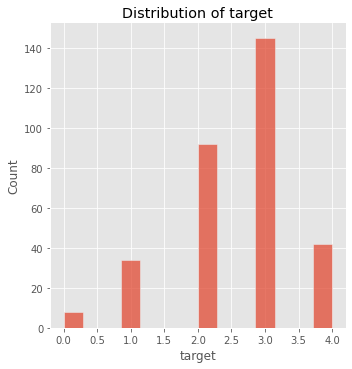

In [3]:
sns.displot(df[target])

plt.title('Distribution of target');

In [4]:
len(df.loc[(df[target] == "Good day")]) / len(df)

0.0

So the prediction points to beat are 20% and 45%. 

Also, the data is imbalanced but it's probably not a great idea to over/undersample since the dataset is so small. I'll leave the balance as-is for now and come back if accuracy needs to be improved.

In [5]:
numerical_features = [f for f in train.columns if train[f].dtype in ['int64', 'float64']]
categorical_features = [f for f in train.columns if train[f].nunique() < 10 and train[f].dtype == "object"]  # that means target is here instead...

# Feature selection

I can mostly decide the features because I know the dataset. 

In [9]:
features = numerical_features + categorical_features
X = train[features].copy()
X_test = test[features].copy()

# df[features][df[features].isna().any(axis=1)]  # search for NaNs

(!) Social media isn't as accurate as it could be because I wasn't counting strava for a while. So there's some manual data improvement to be doing.

I guess I could technically just test it on this test set for starters. That's pretty bad practice, but it should give me a rough idea of how predictive this is. 

In [10]:
# preprocess data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


I don't have any numericals or categoricals to impute, but it's probably fine to leave that in just in case. 

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)  # very basic model (?) plot change in performance vs training time?

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [12]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print("Accuracy scores (in %):\n", scores*100)
print("Average accuracy score (across experiments):")
print(scores.mean()*100)

Accuracy scores (in %):
 [37.5        43.75       52.08333333 43.75       39.58333333]
Average accuracy score (across experiments):
43.33333333333334


Wow, that's kind of low. But not that surprising give that I just gave it a bunch of numbers. 

(?) are there too many folds? train performance is bad but test is good...

In [13]:
clf.fit(X, y)
clf.score(X_test, y_test)

0.5802469135802469

In [14]:
print(clf)
print(clf.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical_features))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Productive Hours',
                                                   'Productive AI Hours',
                                                   'Unproductive Hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Do you want to take this '
                                                   'form today?',
                            

In [17]:
# test_predictions

def getKey(dct,value):  # works for unique values; might be better to reverse dict instead
     return [key for key in dct if (dct[key] == value)]
    
getKey(target_map, model.predict([[
    8, 5, 2,  # prod, ai, unprod
    0, 1,  # take form n/y
    0, 1,  # exercise n/y
    0, 1,  # social n/y
    0, 1,  # sleep n/y
    0, 1,  # tech n/y
    1, 0,  # friends n/y
]]))  # now i need a ton of features to predict...

['Incredible day']

this is how my actual next day went and it predicted it correctly.

I think I just want to be better than picking the same guess every time. Random would be 20% expected accuracy, I need to do exploratory analysis to determine what the most common value is (e.g. if I just guessed "okay day" every day). I hope it's under 50%.



Limiting the features to 8 decreases predictive power, which is expected. But it's more consistent with the definition of the data.